# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [17:26:43.405] [25114] 150 logging_/<module>: {logging_yaml: None}

INFO     [17:26:43.864] [25114]  32 api.server_globals/init

DEBUG    [17:26:43.876] [25114]  75 api.server_globals/load: load_search...

INFO     [17:26:44.241] [25114]  79 api.server_globals/load: load_search (took 0.359s)

DEBUG    [17:26:44.247] [25114]  75 api.server_globals/load: load_xc_meta...

INFO     [17:26:44.708] [25114]  79 api.server_globals/load: load_xc_meta (took 0.454s)

DEBUG    [17:26:44.715] [25114]  75 api.server_globals/load: load_feat_info...

INFO     [17:26:44.722] [25114] 110 api.server_globals/load_feat_info

INFO     [17:26:44.729] [25114]  79 api.server_globals/load: load_feat_info (took 0.007s)

WARNING  [17:26:44.736] [25114]  73 api.server_globals/load: load_search_recs [skipped]

INFO     [17:26:44.742] [25114]  34 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

search_recs(**{'cache_type': 'hybrid'})

INFO     [17:26:44.907] [25114] 601 api.recs/get_search_recs

INFO     [17:26:44.923] [25114] 150 payloads/df_cache_hybrid: Hit: payloads/search_recs-version[7],limit[10],audio_s[10],countries_k[na],com_names_k[ca],num_recs[None]-b6cd6b7

INFO     [17:26:45.403] [25114] 167 payloads/df_cache_hybrid: Hit: Read api/lite.parquet (36.2 kB) [0.461s]

INFO     [17:26:45.423] [25114] 179 payloads/df_cache_hybrid: Hit: Read api/bytes-audio_bytes.parquet (566.9 kB) [0.005s]

INFO     [17:26:45.438] [25114] 179 payloads/df_cache_hybrid: Hit: Read api/bytes-spectro_bytes.parquet (162.6 kB) [0.002s]

INFO     [17:26:45.451] [25114] 186 payloads/df_cache_hybrid: Hit: Read api/feat-f_preds.npy (13.4 kB) [float32, 0.001s]

INFO     [17:26:45.465] [25114] 186 payloads/df_cache_hybrid: Hit: Read api/feat-feat.npy (60.1 kB) [float32, 0.001s]

INFO     [17:26:45.472] [25114] 189 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [17:26:45.497] [25114] 200 payloads/df_cache_hybrid: Hit [0.560s]

Mobile: Ensure dirs: audio_bytes: [

] |   0% (9) |  0.0s

Mobile: Ensure dirs: audio_bytes: [

################################################################

] | 100% (9) |  0.1s

Mobile: Write files: audio_bytes: [

] |   0% (10) |  0.0s

Mobile: Write files: audio_bytes: [

###############################################################

] | 100% (10) |  0.1s

Mobile: Ensure dirs: spectro_bytes: [

] |   0% (9) |  0.0s

Mobile: Ensure dirs: spectro_bytes: [

##############################################################

] | 100% (9) |  0.1s

Mobile: Write files: spectro_bytes: [

] |   0% (10) |  0.0s

Mobile: Write files: spectro_bytes: [

#############################################################

] | 100% (10) |  0.1s

INFO     [17:26:46.203] [25114] 274 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (331) [0.126s]

INFO     [17:26:46.220] [25114] 307 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (10) [0.000s]

INFO     [17:26:46.230] [25114] 307 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (10) [0.000s]

INFO     [17:26:46.326] [25114] 320 payloads/df_cache_hybrid: Mobile: Write mobile-version[0]/search_recs/search_recs.sqlite3 [16.4 kB, 0.084s]

INFO     [17:26:46.334] [25114] 320 payloads/df_cache_hybrid: Mobile: Write payload [0.824s]

,dir,file,size,frac
5,api,TOTAL,839232,1.000
1,api,api/bytes-audio_bytes.parquet,566898,0.675
2,api,api/bytes-spectro_bytes.parquet,162612,0.194
4,api,api/feat-feat.npy: float32,60128,0.072
0,api,api/lite.parquet,36226,0.043
3,api,api/feat-f_preds.npy: float32,13368,0.016
9,mobile-version[0],TOTAL,593920,1.000
6,mobile-version[0],mobile-version[0]/search_recs/audio/,442368,0.745
7,mobile-version[0],mobile-version[0]/search_recs/spectro/,135168,0.228
8,mobile-version[0],mobile-version[0]/search_recs/search_recs.sqlite3,16384,0.028


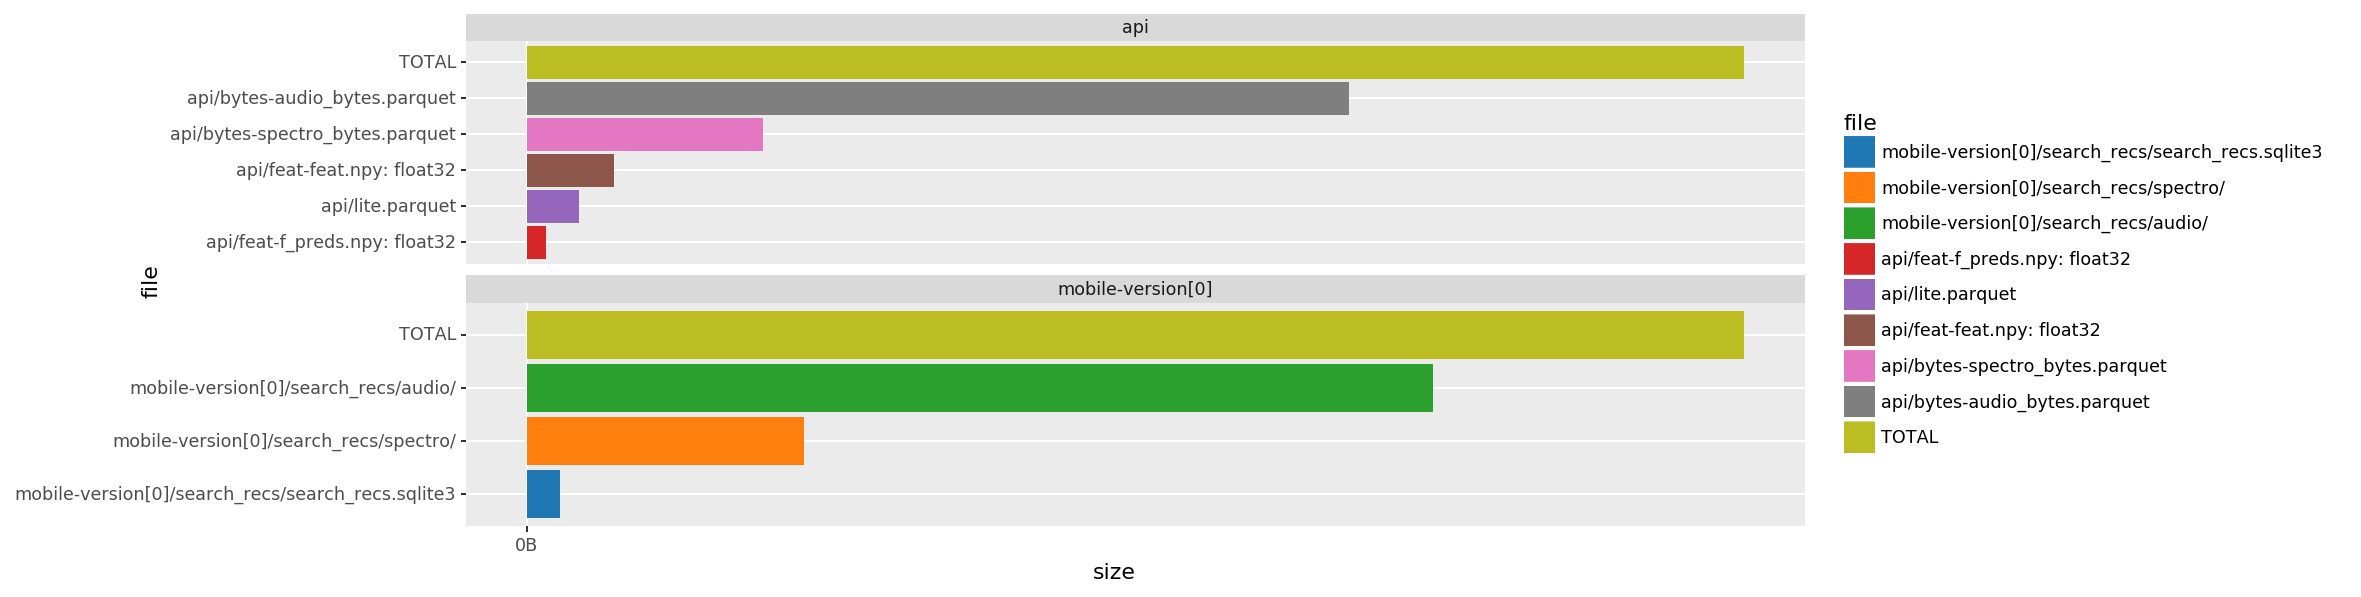

<ggplot: (-9223372036528489356)>

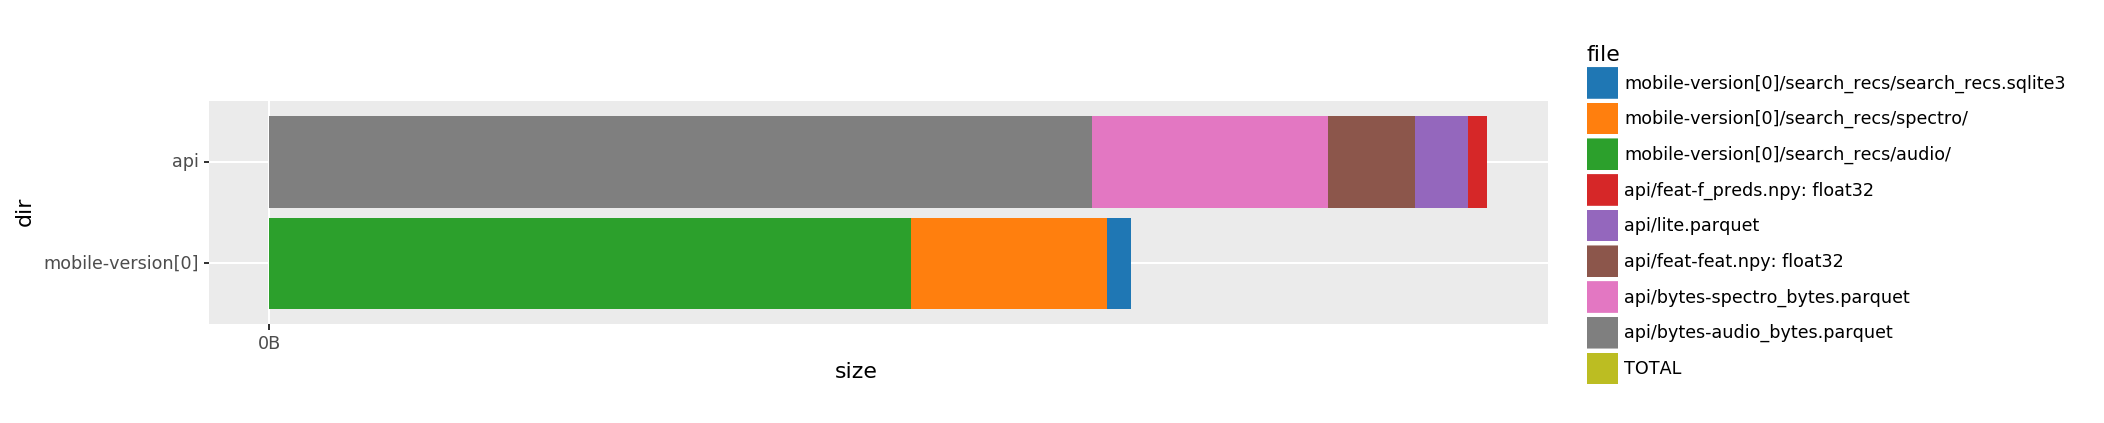

<ggplot: (326511438)>

,size,type,0
xc_id,36,int,417610
feat,104,ndarray,[ 6.140e-02 -2.948e-02 1.953e-02 -3.798e-02 2.723e-02 -2.374e-03 5.391e-02 -5.180e-02 1.074e-01 -2.686e-02 -1.881e-01 9.991e-02 -1.477e-02 -7.756e-02 9.021e-02 -1.45...
f_preds,104,ndarray,[2.549e-03 1.458e-03 1.498e-04 1.324e-03 6.637e-04 2.818e-03 3.106e-03 1.472e-03 2.511e-03 4.366e-03 3.564e-04 9.183e-04 5.002e-03 9.269e-03 4.268e-03 2.612e-03 3.691e-04 ...
background,80,list,"['Chipping Sparrow (Spizella passerina)', 'Black-backed Woodpecker (Picoides arcticus)', ""Audubon's Warbler (Setophaga auduboni)"", 'Hermit Warbler (Setophaga occidentalis)'..."
background_species,80,list,"['CHSP', 'BBWO', ""Audubon's Warbler"", 'HEWA']"


In [ ]:
log_levels({
    'payloads': 'INFO',
    # 'payloads': 'DEBUG',
})
kwargss = [
    # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss
    dict(cache_type='hybrid'),                # Simulate cache hit
]
search_recss = []
for i, kwargs in enumerate(kwargss):
    if i > 0: print()
    print(f'search_recs(**{kwargs})')
    get_search_recs.cache_clear()
    search_recs = get_search_recs(**kwargs,
        write_mobile_payload=True,
        plot_sizes=True,
    )
    search_recss.append(search_recs)
    display(search_recs
        [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
        [2:3].reset_index(drop=True).T
        .pipe(df_assign_first,
            size=lambda df: df.T.memory_usage(deep=True),
            type=lambda df: df[0].map(lambda x: type(x).__name__),
        )
    )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]